In [106]:
import statistics
import joblib
from joblib import Parallel, delayed
from joblib.externals.loky import set_loky_pickler
set_loky_pickler("dill")
import tqdm
from tqdm.contrib import tzip
import multiprocessing
import os
import re
import glob
import pandas as pd
import numpy as np

import dataset_statistics
import query_sumo_dataset
import process_pcaps
import statistics_utils


NUM_CORES = multiprocessing.cpu_count()

In [107]:
onion_popularities = [0.44202, 0.00249, 0.00262, 0.00276, 0.15469, 0.00294, 0.00312, 0.00313, 0.08579, 0.00347, 0.00348, 0.00404, 0.05591, 0.00411, 0.0042, 0.00475, 0.03966, 0.00492, 0.00522, 0.00528, 0.03001, 0.00634, 0.00679, 0.00765, 0.02396, 0.00849, 0.00958, 0.01076, 0.01903, 0.01236, 0.01349, 0.01694]
onion_popularities.sort(reverse=True)
print(onion_popularities)

[0.44202, 0.15469, 0.08579, 0.05591, 0.03966, 0.03001, 0.02396, 0.01903, 0.01694, 0.01349, 0.01236, 0.01076, 0.00958, 0.00849, 0.00765, 0.00679, 0.00634, 0.00528, 0.00522, 0.00492, 0.00475, 0.0042, 0.00411, 0.00404, 0.00348, 0.00347, 0.00313, 0.00312, 0.00294, 0.00276, 0.00262, 0.00249]


In [108]:
onion_pages = {
    'onion1': 'http://localhost/onionRealPages2022/b4bbcjkuimxggedoqahicvimcw7xutwmp4omh2lz7cskuaaxoxog6cad/',
    'onion32': 'http://localhost/onionRealPages2022/hackerr6x5joaf2quyop3g3q3jyuqbpkoydtta5a53lhx25k43e6uiad/',
    'onion31': 'http://localhost/onionRealPages2022/fxrx6qvrri4ldt7dhytdvkuakai75bpdlxlmner6zrlkq34rpcqpyqyd/',
   'onion30': 'http://localhost/onionRealPages2022/liibeu7vlwaumwrstixzcpkqucdfln5m4sn5buciwkgbn6aet2xokzyd/',
    'onion2': 'http://localhost/onionRealPages2022/biden6qccqo5iqzvnjgpivp3owp2v5xodgwenqdh5wsq7zzfhnvodjqd/',
    'onion29': 'http://localhost/onionRealPages2022/f5a4wxs3e3hsuajufy4sa52jj2vb3khctzrwaka5tanew4uvh3lsrhid/',
    'onion28': 'http://localhost/onionRealPages2022/epxfqkb7kyuenlbsitgaj5zht4y33uqj4ftswmhrdwx3b252xj3ajpad/',
    'onion27': 'http://localhost/onionRealPages2022/duvlyvpbhwl37a2hisxrr4o2sceq2uygfmhpz3wcidf5xz5yjvxvgjid/',
   'onion3': 'http://localhost/onionRealPages2022/bizz4kwy566gxae32fkjybarded4caeqatyj4jvoxpkrx3wrzrq77yad/',
   'onion26': 'http://localhost/onionRealPages2022/dse6rlfwpgdohd33ulg623rpzy3zv5y5whfw23jznd3xu4o47vy6xmqd/',
    'onion25': 'http://localhost/onionRealPages2022/l5jcgrava4h2joxfcnyas7qvkqjdzeywnsqntrmwqpfq7u4rz2iwjzyd/',
    'onion24': 'http://localhost/onionRealPages2022/dbayuapytcowfz2nnfik3jayno4njibl45t77r3eartihtq6igtaqtqd/',
    'onion4': 'http://localhost/onionRealPages2022/calcu2cjww3qkdlzllf35qsbstk4umxxi76lnttc3o63bd2gbcidqyqd/',
    'onion23': 'http://localhost/onionRealPages2022/coinpigv67cccbkeoddtthduoy65uwtc7rs3pvwtln2xefcrnkhf3sad/',
    'onion22': 'http://localhost/onionRealPages2022/dcrdata5oppwcotlxkrlsp6afncnxvw54sw6jqftc4bjytm4rn27j3ad/',
    'onion21': 'http://localhost/onionRealPages2022/darkfox7kukhe3b2ufsvuknskyhzdjc7a724mh4zrkipeg7pkaikm6yd/',
    'onion5': 'http://localhost/onionRealPages2022/mixtumjzn2tsiusfkdhutntamspsg43kgt764qbdaxjebce4h6fcfiad/',
    'onion20': 'http://localhost/onionRealPages2022/mp3fpv6xbrwka4skqliiifoizghfbjy5uyu77wwnfruwub5s4hly2oid/',
    'onion19': 'http://localhost/onionRealPages2022/mvj5hwvun4dalhggvh6p5gnclggywrxeflrfaxcpzxo7efseikjj6wid/',
    'onion18': 'http://localhost/onionRealPages2022/naturelwg7o3bhnhwcmn6svzoekxkl3pv365krgmdpckonf5xvarlkid/',
    'onion6': 'http://localhost/onionRealPages2022/nq4zyac4ukl4tykmidbzgdlvaboqeqsemkp4t35bzvjeve6zm2lqcjid/',
    'onion17': 'http://localhost/onionRealPages2022/ofrx66cgm4vzzl4y6brb26anu7uaf5ul4coudu65mpnu44rmfae3fgyd/',
    'onion16': 'http://localhost/onionRealPages2022/ojqllc2vr6nttoddzx3yf34qonoqs5qks6jewnfuv256jzfkj724isqd/',
    'onion15': 'http://localhost/onionRealPages2022/okj2scf6yptajq2slvahni4u5jrattnr4u4mukokl3d7wq7erygn6bad/',
    'onion7': 'http://localhost/onionRealPages2022/orc52yt3qnatcmwwbiht4n6qvbxdeapzzvp6xaiwnuta2c2lqn4afdad/',
    'onion14': 'http://localhost/onionRealPages2022/p3s3h32smv45dsvgl63tmsyhl2etq6yuemsmwsjn6z4wjrsltfapihid/',
    'onion13': 'http://localhost/onionRealPages2022/p7gettng6fudmj4gowkl6pnsvbqw3mo44pzwjyxaqo5hjpnonf457qad/',
    'onion12': 'http://localhost/onionRealPages2022/pharmacy42hblqssvwizqvrwmy7oec5sfgjtr7hy6dup3t2lf2xzitqd/',
    'onion8': 'http://localhost/onionRealPages2022/piratec4cdgbjqzny6sykeqeylarm67teyhroxez3y5fmszrr5lmbgad/',
    'onion11': 'http://localhost/onionRealPages2022/psyshopshweetovp4em654waimmcjsf7eqifwe2d4qhnluk2b24r6dqd/',
    'onion10': 'http://localhost/onionRealPages2022/pvhwsb7a3d2oq73xtr3pzvmrruvswyqgkyahcb7dmbbfftr4qtsmvjid/',
    'onion9': 'http://localhost/onionRealPages2022/r7lscyg5lncab4gm77ldshetqoutj3btq53aw44ixnz3iinc3oaz7qqd/' 
}

print(len(onion_pages))

32


In [109]:
onion_categories = {
    'onion1': 'Hacking',
    'onion32': 'Hacking',
    'onion31': 'Credit cards',
    'onion30': 'Social networking', # mastodon? is that a thing?
    'onion2': 'Login required',
    'onion29': 'Credit cards',
    'onion28': 'Marketplace',
    'onion27': 'Onion sites directory',
    'onion3': 'Credit cards',
    'onion26': 'Drugs',
    'onion25': 'Scam list',
    'onion24': 'Drugs',
    'onion4': 'Credit cards',
    'onion23': 'Bitcoin wallet',
    'onion22': 'Bitcoin ledger',
    'onion21': 'Hacking',
    'onion5': 'Bitcoin',
    'onion20': 'Bitcoin wallet and mixer',
    'onion19': 'Hacking',
    'onion18': 'Drugs',
    'onion6': 'Leaked data',
    'onion17': 'Scam list',
    'onion16': 'Bitcoin generator',
    'onion15': 'Apple products',
    'onion7': 'Drugs',
    'onion14': 'Documents',
    'onion13': 'Bitcoin giveaway',
    'onion12': 'Drugs',
    'onion8': 'Hacking',
    'onion11': 'Drugs',
    'onion10': 'Scam list',
    'onion9': 'Poison'
}

In [110]:
onion_path_to_name = {
    'onion1': 'os1-os-train-1',
    'onion32': 'os2-os-train-1',
    'onion31': 'os3-os-train-1',
    'onion30': 'os4-os-train-1',
    'onion2': 'os1-os-train-2',
    'onion29': 'os2-os-train-2',
    'onion28': 'os3-os-train-2',
    'onion27': 'os4-os-train-2',
    'onion3': 'os1-os-train-3',
    'onion26': 'os2-os-train-3',
    'onion25': 'os3-os-train-3',
    'onion24': 'os4-os-train-3',
    'onion4': 'os1-os-train-4',
    'onion23': 'os2-os-train-4',
    'onion22': 'os3-os-train-4',
    'onion21': 'os4-os-train-4',
    'onion5': 'os1-os-train-5',
    'onion20': 'os2-os-train-5',
    'onion19': 'os3-os-train-5',
    'onion18': 'os4-os-train-5',
    'onion6': 'os1-os-train-6',
    'onion17': 'os2-os-train-6',
    'onion16': 'os3-os-train-6',
    'onion15': 'os4-os-train-6',
    'onion7': 'os1-os-train-7',
    'onion14': 'os2-os-train-7',
    'onion13': 'os3-os-train-7',
    'onion12': 'os4-os-train-7',
    'onion8': 'os1-os-train-8',
    'onion11': 'os2-os-train-8',
    'onion10': 'os3-os-train-8',
    'onion9': 'os4-os-train-8'
}

In [111]:
def extract_number(element):
    match = re.search(r'\d+', element)
    if match:
        return int(match.group())
    else:
        return 0

In [112]:
def get_requests_count(url):
    from seleniumwire import webdriver

    print("get_requests_count {}", url)
    network_requests = []
    resource_sizes = []

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')

    driver = webdriver.Chrome('chromedriver', options=chrome_options)
    driver.get(url)

    # Retrieve all requests from the response object
    for request in driver.requests:
        if request.response:
            request_info = {
                'url': request.url,
                'status_code': request.response,
                'headers': request.response.headers['Content-Type'],
            }
            network_requests.append(request_info)
            
            size = request.response.headers.get('Content-Length')
            if size:
                resource_sizes.append(int(size))
            else:
                resource_sizes.append(0)

    driver.quit()

    return len(network_requests), resource_sizes, sum(resource_sizes)

In [113]:
def get_local_pages(url, onion_url):
    from bs4 import BeautifulSoup
    from urllib.parse import urljoin
    from urllib.parse import urlparse
    import requests

    print("--- get_local_pages for :", url)
    visited_pages = set()
    local_pages = set()
    base_url = urlparse(url).netloc
    #base_url = urllib.parse.urlparse(url).netloc
    print("--- base_url", base_url)

    # Initialize a list with the starting URL
    urls_to_crawl = {url} # set to avoid adding repeats

    while urls_to_crawl:
        current_url = urls_to_crawl.pop()

        try:
            response = requests.get(current_url)
            soup = BeautifulSoup(response.text, 'html.parser')

            visited_pages.add(current_url)

            for link in soup.find_all('a'):
                href = link.get('href')
                if href:
                    absolute_url = urljoin(current_url, href)
                    parsed_url = urlparse(absolute_url)
                    
                    if parsed_url.netloc == base_url and absolute_url not in visited_pages:
                        local_pages.add(absolute_url)
                        urls_to_crawl.add(absolute_url)
                    else:
                        onion_url = onion_url.split("/")[-1]
                        if onion_url in absolute_url:
                            local_url = "http://localhost/onionRealPages2022/" + onion_url.split(".onion")[0] + "/"
                            absolute_url = absolute_url.replace(onion_url, local_url)
                            local_pages.add(absolute_url)
                            urls_to_crawl.add(absolute_url)

        except requests.exceptions.RequestException:
            pass

    return local_pages

In [115]:
def crawl_pages(results_file):
    results = {}

    onions = [key for key, value in sorted(onion_pages.items())]
    onion_urls = [value for key, value in sorted(onion_pages.items())]
    pages = [value for key, value in sorted(onion_pages.items())]
   
    with tqdm.tqdm(total=len(onions)) as pbar:
        parallel_results = Parallel(n_jobs=NUM_CORES)(delayed(get_local_pages)(page, onion_url) for onion, onion_url, page in tzip(onions, onion_urls, pages, leave=False))
        pbar.update()
    for onion, page, local_pages in zip(onions, pages, parallel_results):

    #for onion, page in zip(onions, pages):
        #local_pages = get_local_pages(page)
        print(f"Number of local visitable pages for {onion}: {len(local_pages)}")
        #print("Local pages:")
        results[onion] = {
            'onion': onion,
            'category': onion_categories[onion],
            'num_visitable_pages': len(local_pages),
            'num_requests': [],
            'resource_sizes': [],
            'total_page_size': []
        }

        max_pages_to_visit = 50
        if len(local_pages) >= max_pages_to_visit:
            pages_to_visit = list(local_pages)[ : max_pages_to_visit]
        else:
            pages_to_visit = list(local_pages)

        with tqdm.tqdm(total=max_pages_to_visit) as pbar:
            parallel_results = Parallel(n_jobs=NUM_CORES)(delayed(get_requests_count)(page[0]) for page in tzip(pages_to_visit, leave=False))
            pbar.update()
        for num_requests, resource_sizes, page_size in parallel_results:

        #for page in pages_to_visit:
            #print("--- Page: ", page)

            #num_requests, resource_sizes, page_size = get_requests_count(page)

            results[onion]['total_page_size'].append(page_size)
            results[onion]['num_requests'].append(num_requests)
            results[onion]['resource_sizes'] += resource_sizes

        print("resource_sizes", results[onion]['resource_sizes'])
        print("page_size", results[onion]['total_page_size'])
        print("num_requests", results[onion]['num_requests'])


        # Gather statistics
        #if results[onion]['num_requests'] == 0:
        average_num_requests = statistics.mean(results[onion]['num_requests'])
        maximum_num_requests = max(results[onion]['num_requests'])
        minimum_num_requests = min(results[onion]['num_requests'])
        if len(results[onion]['num_requests']) > 1:
            std_dev_num_requests = statistics.stdev(results[onion]['num_requests'])
        else:
            std_dev_num_requests = 0
        results[onion]['avg_num_requests'] = average_num_requests
        results[onion]['max_num_requests'] = maximum_num_requests
        results[onion]['min_num_requests'] = minimum_num_requests
        results[onion]['std_num_requests'] = std_dev_num_requests

        average_resource_size = statistics.mean(results[onion]['resource_sizes'])
        maximum_resource_size = max(results[onion]['resource_sizes'])
        minimum_resource_size = min(results[onion]['resource_sizes'])
        if len(results[onion]['resource_sizes']) > 1:
            std_dev_resource_size = statistics.stdev(results[onion]['resource_sizes'])
        else:
            std_dev_resource_size = 0
        results[onion]['avg_resource_size'] = average_resource_size
        results[onion]['max_resource_size'] = maximum_resource_size
        results[onion]['min_resource_size'] = minimum_resource_size
        results[onion]['std_resource_size'] = std_dev_resource_size

        average_total_page_size = statistics.mean(results[onion]['total_page_size'])
        maximum_total_page_size = max(results[onion]['total_page_size'])
        minimum_total_page_size = min(results[onion]['total_page_size'])
        if len(results[onion]['total_page_size']) > 1:
            std_dev_total_page_size = statistics.stdev(results[onion]['total_page_size'])
        else:
            std_dev_total_page_size = 0
        results[onion]['avg_total_page_size'] = average_total_page_size
        results[onion]['max_total_page_size'] = maximum_total_page_size
        results[onion]['min_total_page_size'] = minimum_total_page_size
        results[onion]['std_total_page_size'] = std_dev_total_page_size


        # Print the statistics
        print(f"Page: {page}")
        print(f"Number of visitable webpages: {results[onion]['num_visitable_pages']}")
        print(f"Number of requests per page: {average_num_requests} (Min: {minimum_num_requests}, Max: {maximum_num_requests}, Std Dev: {std_dev_num_requests})")
        print(f"Average resource size: {average_resource_size} bytes (Min: {minimum_resource_size} bytes, Max: {maximum_resource_size} bytes, Std Dev: {std_dev_resource_size})")
        print(f"Average total page size: {average_total_page_size} bytes (Min: {minimum_total_page_size} bytes, Max: {maximum_total_page_size} bytes, Std Dev: {std_dev_total_page_size})")


        statistics_utils.save_dict_to_file(results, results_file)

    
    return results

In [116]:
# Taken from: https://stackoverflow.com/questions/69520456/how-can-i-plot-a-cdf-in-matplotlib-without-binning-my-data
def ecdf4plot(seq, assumeSorted = False):
    """
    In:
    seq - sorted-able object containing values
    assumeSorted - specifies whether seq is sorted or not
    Out:
    0. values of support at both points of jump discontinuities
    1. values of ECDF at both points of jump discontinuities
       ECDF's true value at a jump discontinuity is the higher one    """
    if len(seq) == 0:
        return [], []
    if not assumeSorted:
        seq = sorted(seq)
    prev = seq[0]
    n = len(seq)
    support = [prev]
    ECDF = [0.]
    for i in range(1, n):
        seqi = seq[i]
        if seqi != prev:
            preP = i/n
            support.append(prev)
            ECDF.append(preP)
            support.append(seqi)
            ECDF.append(preP)
            prev = seqi
    support.append(prev)
    ECDF.append(1.)
    return support, ECDF

In [120]:
def custom_sort_key(item):
    return int(item[5:])

In [121]:
def plot_onion_statistics(results):
    import matplotlib.pyplot as plt
    from matplotlib.ticker import ScalarFormatter

    import datetime


    plt.rcParams["figure.figsize"] = (40,15)
    tick_labels_font_size = 22
    axis_labels_font_size = 26
    legend_font_size = 22

    fig, axs = plt.subplots(
                        nrows=2, 
                        ncols=3)
    
    onions = list(results.keys())
    onion_indexes = np.arange(len(onions))
    sorted_onions = sorted(onions, key=custom_sort_key)
    
    n_visitable_pages = [results[onion]['num_visitable_pages'] for onion in sorted_onions]
    n_visitable_pages_x, n_visitable_pages_y = ecdf4plot(n_visitable_pages)
    axs[0, 0].plot(n_visitable_pages_x, n_visitable_pages_y)
    axs[0, 0].set_xlabel("# visitable pages", fontsize=axis_labels_font_size)
    axs[0, 0].set_ylabel("CDF", fontsize=axis_labels_font_size)
    #axs[0, 0].set_xticklabels(onions)


    page_sizes = [results[onion]['total_page_size'] for onion in sorted_onions]
    bplot = axs[0, 1].boxplot(page_sizes,
                    vert=True,
                    patch_artist=True,
                    labels=sorted_onions)
    axs[0, 1].set_xlabel("Onion service", fontsize=axis_labels_font_size)
    axs[0, 1].set_ylabel("Total page size (bytes)", fontsize=axis_labels_font_size)


    resource_sizes = [results[onion]['resource_sizes'] for onion in sorted_onions]
    bplot = axs[0, 2].boxplot(resource_sizes,
                    vert=True,
                    patch_artist=True,
                    labels=sorted_onions)
    axs[0, 2].set_xlabel("Onion service", fontsize=axis_labels_font_size)
    axs[0, 2].set_ylabel("Resource size (bytes)", fontsize=axis_labels_font_size)


    num_requests = [results[onion]['num_requests'] for onion in sorted_onions]
    bplot = axs[1, 0].boxplot(num_requests,
                    vert=True,
                    patch_artist=True,
                    labels=sorted_onions)
    axs[1, 0].set_xlabel("Onion service", fontsize=axis_labels_font_size)
    axs[1, 0].set_ylabel("# requests", fontsize=axis_labels_font_size)


    onion_labels = onions
    received_requests = statistics_utils.count_requests_received_by_onion(onion_pages)
    # Sort the labels and values together based on the values array
    sorted_pairs = sorted(zip(onion_labels, received_requests), key=lambda x: x[1], reverse=True)
    # Extract the sorted labels and values separately
    onion_labels, received_requests = zip(*sorted_pairs)
    onion_indexes = np.arange(0, len(onions))
    axs[1, 1].bar(onion_indexes, received_requests)
    #axs[1, 1].set_xticklabels(onion_labels)
    axs[1, 1].set_xticks(onion_indexes, onion_labels)
    axs[1, 1].set_xlabel("Onion service", fontsize=axis_labels_font_size)
    axs[1, 1].set_ylabel("# client requests received", fontsize=axis_labels_font_size)


    received_requests_in_time = statistics_utils.requests_evolution_in_time()
    onion_indexes = np.arange(0, len(onions) + 1)

    start_time = received_requests_in_time[onion_path_to_name[onions[0]]].index[60]  # Replace with your desired start time
    #end_time = start_time + datetime.timedelta(hours=1)  # Set the end time as 1 hour from the start
    end_time = start_time + datetime.timedelta(hours=2)
    # Filter the DataFrame within the specified time range
    desired_time_range_data = {}
    for onion_name, data in received_requests_in_time.items():
        data_in_time_range = data.loc[start_time:end_time]
        data_in_time_range.index = data_in_time_range.index.strftime('%H:%M')
        desired_time_range_data[onion_name] = data_in_time_range

    #axs[1, 2].plot(received_requests_in_time[onion_path_to_name[onions[0]]].index, received_requests_in_time[onion_path_to_name[onions[0]]]['Requests'], label=onions[0])
    axs[1, 2].plot(desired_time_range_data[onion_path_to_name['onion1']].index, desired_time_range_data[onion_path_to_name['onion1']]['Requests'], label='onion1', color='lightblue', linewidth=4)
    axs[1, 2].plot(desired_time_range_data[onion_path_to_name['onion13']].index, desired_time_range_data[onion_path_to_name['onion13']]['Requests'], label='onion13', color='pink', linewidth=4)
    axs[1, 2].plot(desired_time_range_data[onion_path_to_name['onion17']].index, desired_time_range_data[onion_path_to_name['onion17']]['Requests'], label='onion17', color='lightgreen', linewidth=4)
    #minutes_labels = np.arange(0, len(received_requests_in_time[onion_path_to_name[onions[0]]].index), 10)
    #axs[1, 2].set_xticks(received_requests_in_time[onion_path_to_name[onions[0]]].index, minutes_labels)
    #axs[1, 2].set_xticks(minutes_labels, minutes_labels)
    x_ticks = data_in_time_range.index[::10]  # Display every 10th label (adjust as needed)
    axs[1, 2].set_xticks(x_ticks)
    axs[1, 2].set_xlabel("Time windows of 1 minute for a range of 2 hours", fontsize=axis_labels_font_size)
    axs[1, 2].set_ylabel("# client requests received", fontsize=axis_labels_font_size)
    axs[1, 2].legend(fontsize=legend_font_size)


    for ax1 in axs:
        for ax2 in ax1:
            ax2.tick_params(axis='both', labelsize=tick_labels_font_size)
            ax2.tick_params(axis='x', rotation=90)

            # TODO: not working
            # Prevent scientific notation on both axes
            formatter = ScalarFormatter(useOffset=False)
            ax2.yaxis.set_major_formatter(formatter)

            ax2.spines['top'].set_visible(False)
            ax2.spines['right'].set_visible(False)

    plt.subplots_adjust(wspace=0.23, hspace=0.4)
    



In [122]:
def main():

    results_file = 'onion_page_statistics.joblib'

    if os.path.isfile(results_file):
        results = statistics_utils.load_dict_from_file(results_file)
    else:
        results = crawl_pages(results_file)
    
    plot_onion_statistics(results)


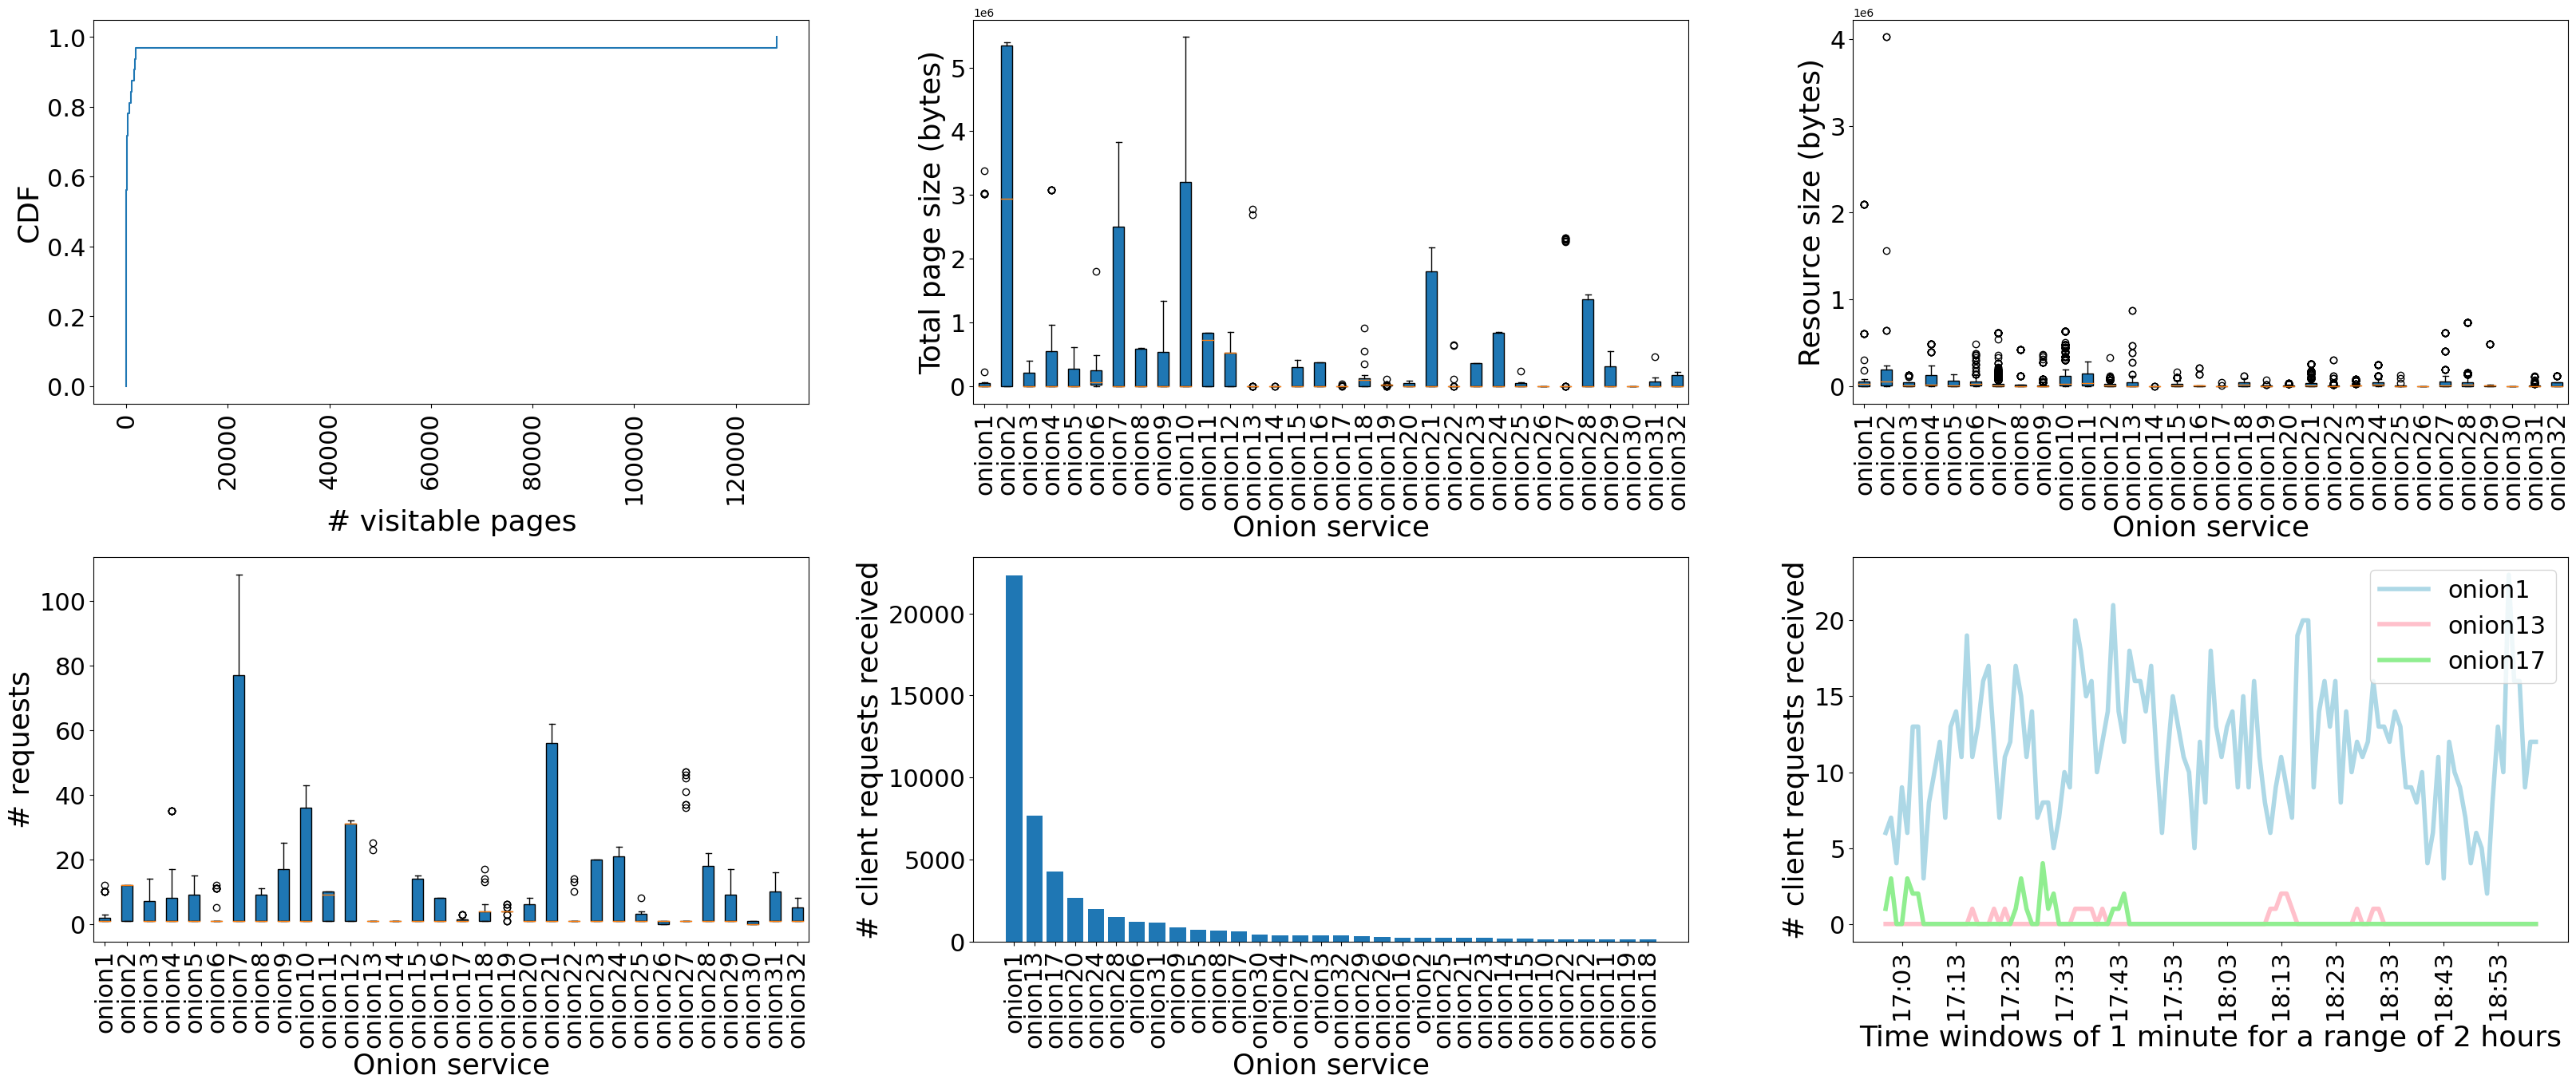

In [123]:
main()